## Общие действия

In [1]:
# Импортируем все необходимое
import ast
import matplotlib.pyplot as plt
from os.path import join
import pandas as pd
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [2]:
# Сделаем так, чтобы matplotlib рисовал все сразу без напоминаний
%matplotlib inline

In [3]:
# Для воспроизводимости результатов зададим:
# - общий параметр для генерации случайных чисел
RANDOM_SEED = 42
# - общую текущую дату
CURRENT_DATE = pd.to_datetime('22/02/2020')

In [4]:
# Для тех, кто будет запускать мой ноутбук на своей машине создаем requirements.txt
!pip freeze > requirements.txt

In [5]:
# Зададим путь к папке с данными
ds_folder = 'data'

# Зададим названия файлов датасетов
mt_ds = 'main_task.csv'
kt_ds = 'kaggle_task.csv'

# Сформируем пути к датасетам
mt_path = join(ds_folder, mt_ds)
kt_path = join(ds_folder, kt_ds)

# Загрузим имеющиеся датасеты
mt_df = pd.read_csv(mt_path)
kt_df = pd.read_csv(kt_path)

In [6]:
# Проанализируем данные из main_task.csv
mt_df.head(1)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643


In [7]:
mt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [8]:
mt_df.nunique()

Restaurant_id        11909
City                    31
Cuisine Style         9007
Ranking              11936
Rating                   9
Price Range              3
Number of Reviews     1459
Reviews              33516
URL_TA               39980
ID_TA                39980
dtype: int64

## Инсайт!!!
Из анализа количества уникальных значений можно сделать следующие выводы:
- Поле Restaurant_id является чем угодно, но только не уникальным идентификатором ресторана. Ориентироваться на эти данные не стоит. 
- На роль уникальных идентификаторов скорее могут претендовать в равной степени как URL_TA, так и ID_TA. Но и тут наблюдаются дубликаты. Посмотрим на них внимательней: 

In [9]:
# Сформируем множество дублирующихся идентификаторов ресторанов на сайте TripAdvisor
duplicated_ids = set(mt_df.groupby('ID_TA')['ID_TA'].count().sort_values(ascending=False)[:20].index)

# Смотрим на непосредственно данные, относящиеся к этим дубликатам
mt_df[mt_df['ID_TA'].apply(lambda x: x in duplicated_ids)].sort_values(by='ID_TA')

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
38946,id_3242,Madrid,NaN,3244.0,5.0,NaN,13.0,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799
13980,id_3239,Madrid,NaN,3241.0,5.0,NaN,13.0,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799
11583,id_3810,Madrid,"['American', 'German', 'European', 'Central Eu...",3812.0,4.0,NaN,8.0,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,d11674463
4732,id_3804,Madrid,"['American', 'German', 'European', 'Central Eu...",3806.0,4.0,NaN,8.0,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,d11674463
26551,id_3240,Madrid,NaN,3242.0,4.5,NaN,7.0,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...,d11698990
26431,id_3238,Madrid,NaN,3240.0,4.5,NaN,7.0,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...,d11698990
10819,id_2197,Madrid,NaN,2199.0,4.5,NaN,16.0,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-C...,d11921719
12628,id_2329,Madrid,NaN,2331.0,4.5,NaN,16.0,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-C...,d11921719
29879,id_3662,Madrid,"['International', 'Mediterranean', 'Spanish', ...",3664.0,4.0,$$ - $$$,52.0,"[['Great Food! Wide Variety.', 'Dinner'], ['11...",/Restaurant_Review-g187514-d11999956-Reviews-S...,d11999956
16920,id_3536,Madrid,"['International', 'Mediterranean', 'Spanish', ...",3538.0,4.0,$$ - $$$,52.0,"[['Great Food! Wide Variety.', 'Dinner'], ['11...",/Restaurant_Review-g187514-d11999956-Reviews-S...,d11999956


#### Эти дубликаты только вносят шум, так что от них лучше избавиться.
## Оказалось наоборот!!! Не удаляем эти дубликаты и точность модели повышается!!! Дружно кекаем!!!

In [10]:
# mt_df.drop_duplicates('ID_TA', inplace=True) # По-умолчанию оставляем первые из дублирующихся строк

In [11]:
# Проанализируем данные из kaggle_task.csv
kt_df.head(1)

,Restaurant_id,Name,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Le Perchoir,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918


In [12]:
kt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   Name               10000 non-null  object 
 2   City               10000 non-null  object 
 3   Cuisine Style      7693 non-null   object 
 4   Ranking            10000 non-null  float64
 5   Price Range        6525 non-null   object 
 6   Number of Reviews  9343 non-null   float64
 7   Reviews            9998 non-null   object 
 8   URL_TA             10000 non-null  object 
 9   ID_TA              10000 non-null  object 
dtypes: float64(2), object(8)
memory usage: 781.4+ KB


In [13]:
# Как видим, в датасете kaggle_task.csv отсутствует признак Rating,
# но добавлен признак с названием ресторана 'Name'

In [14]:
# Добавим признак 'Main' для отделения основной выборки от валидационной
mt_df['Main'] = True
kt_df['Main'] = False

# Недостающие данные по названиям ресторанов в основной выборке заполним названиями вида Name-id, где id - идентификатор ресторана
mt_df['Name'] = mt_df['Restaurant_id'].apply(lambda x: 'Name-'+x)

# Недостающие данные по рейтингу в тестовой выборке заполним нулями
kt_df['Rating'] = 0

# Объединим датасеты в один для полного анализа по всем данным
df = pd.concat([mt_df, kt_df])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Rating             50000 non-null  float64
 5   Price Range        32639 non-null  object 
 6   Number of Reviews  46800 non-null  float64
 7   Reviews            49998 non-null  object 
 8   URL_TA             50000 non-null  object 
 9   ID_TA              50000 non-null  object 
 10  Main               50000 non-null  bool   
 11  Name               50000 non-null  object 
dtypes: bool(1), float64(3), object(8)
memory usage: 4.6+ MB


## 1. Информация о ресторанах

In [16]:
# Создадим справочник с указанием количества ресторанов для каждого города, присутствующего в датасете
res_count = {
    'Paris': 17593,
    'Stockholm': 3131,
    'London': 22366,
    'Berlin': 8110, 
    'Munich': 3367,
    'Oporto': 2060, 
    'Milan': 7940,
    'Bratislava': 1331,
    'Vienna': 4387, 
    'Rome': 12086,
    'Barcelona': 10086,
    'Madrid': 11562,
    'Dublin': 2706,
    'Brussels': 3703,
    'Zurich': 1901,
    'Warsaw': 3210,
    'Budapest': 3445, 
    'Copenhagen': 2637,
    'Amsterdam': 4189,
    'Lyon': 2833,
    'Hamburg': 3501, 
    'Lisbon': 4985,
    'Prague': 5850,
    'Oslo': 1441, 
    'Helsinki': 1661,
    'Edinburgh': 2248,
    'Geneva': 1753,
    'Ljubljana': 647,
    'Athens': 2814,
    'Luxembourg': 759,
    'Krakow': 1832       
}

### Добавленный числовой признак № 1. Количество ресторанов в городе

In [17]:
# Создадим новый признак 'Restaurants Count', отражающий общее количество ресторанов в городе, в котором расположен данный ресторан
df['Restaurants Count'] = df['City'].map(res_count)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Rating             50000 non-null  float64
 5   Price Range        32639 non-null  object 
 6   Number of Reviews  46800 non-null  float64
 7   Reviews            49998 non-null  object 
 8   URL_TA             50000 non-null  object 
 9   ID_TA              50000 non-null  object 
 10  Main               50000 non-null  bool   
 11  Name               50000 non-null  object 
 12  Restaurants Count  50000 non-null  int64  
dtypes: bool(1), float64(3), int64(1), object(8)
memory usage: 5.0+ MB


In [19]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Main,Name,Restaurants Count
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,True,Name-id_5569,17593
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,True,Name-id_1535,3131
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,True,Name-id_352,22366
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,True,Name-id_3456,8110
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,True,Name-id_615,3367


### Добавленный числовой признак № 2. Относительный ранг

In [20]:
# А теперь создадим относительный признак 'Relative Ranking' = 'Ranking' / 'Restaurants Count'
df['Relative Ranking'] = df['Ranking'] / df['Restaurants Count']

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Rating             50000 non-null  float64
 5   Price Range        32639 non-null  object 
 6   Number of Reviews  46800 non-null  float64
 7   Reviews            49998 non-null  object 
 8   URL_TA             50000 non-null  object 
 9   ID_TA              50000 non-null  object 
 10  Main               50000 non-null  bool   
 11  Name               50000 non-null  object 
 12  Restaurants Count  50000 non-null  int64  
 13  Relative Ranking   50000 non-null  float64
dtypes: bool(1), float64(4), int64(1), object(8)
memory usage: 5.4+ MB


In [22]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Main,Name,Restaurants Count,Relative Ranking
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,True,Name-id_5569,17593,0.316603
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,True,Name-id_1535,3131,0.490897
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,True,Name-id_352,22366,0.015783
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,True,Name-id_3456,8110,0.426387
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,True,Name-id_615,3367,0.184437


## 2. Информация о ценах

In [23]:
# Посмотрим на данные в признаке 'Price Range'
df['Price Range'].unique()

array(['$$ - $$$', nan, '$$$$', '$'], dtype=object)

In [24]:
# Следуя рекомендациям более опытных коллег, до заполнения отсутствующих данных
# создадим бинарный признак отсутствия данных 'Price Range Was NAN'
df['Price Range Was NAN'] = df['Price Range'].isna()

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Restaurant_id        50000 non-null  object 
 1   City                 50000 non-null  object 
 2   Cuisine Style        38410 non-null  object 
 3   Ranking              50000 non-null  float64
 4   Rating               50000 non-null  float64
 5   Price Range          32639 non-null  object 
 6   Number of Reviews    46800 non-null  float64
 7   Reviews              49998 non-null  object 
 8   URL_TA               50000 non-null  object 
 9   ID_TA                50000 non-null  object 
 10  Main                 50000 non-null  bool   
 11  Name                 50000 non-null  object 
 12  Restaurants Count    50000 non-null  int64  
 13  Relative Ranking     50000 non-null  float64
 14  Price Range Was NAN  50000 non-null  bool   
dtypes: bool(2), float64(4), int64(1), obj

In [26]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Main,Name,Restaurants Count,Relative Ranking,Price Range Was NAN
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,True,Name-id_5569,17593,0.316603,False
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,True,Name-id_1535,3131,0.490897,True
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,True,Name-id_352,22366,0.015783,False
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,True,Name-id_3456,8110,0.426387,True
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,True,Name-id_615,3367,0.184437,False


In [27]:
df['Number of Reviews'].value_counts()

2.0       2403
3.0       2042
4.0       1707
5.0       1471
6.0       1258
          ... 
4080.0       1
972.0        1
2036.0       1
1201.0       1
1543.0       1
Name: Number of Reviews, Length: 1573, dtype: int64

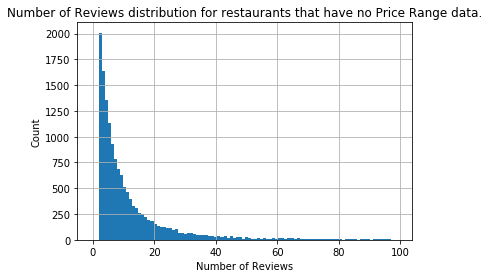

In [28]:
# Как видно, кроме незаполненных данных есть три типа диапазонов цен '$', '$$-$$$' и '$$$$'.
# Посмотрим на гистограмму количества отзывов для тех ресторанов, по которым отсутствует
# информация о диапазоне цен.
plt.xlabel('Number of Reviews')
plt.ylabel('Count')
plt.title('Number of Reviews distribution for restaurants that have no Price Range data.')
df[df['Price Range'].isna()]['Number of Reviews'].hist(bins=100, range=(0, 99))

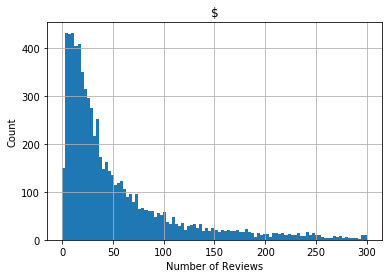

In [29]:
# Посмотрим на гистаграмму распределения количества отзывов 
# о ресторанах для разных диапазонов цен.
plt.xlabel('Number of Reviews')
plt.ylabel('Count')
plt.title('$')
df[df['Price Range'] == '$']['Number of Reviews'].hist(bins=100, range=(0, 300))

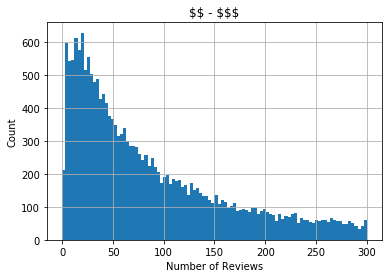

In [30]:
plt.xlabel('Number of Reviews')
plt.ylabel('Count')
plt.title('\$\$ - \$\$\$')
df[df['Price Range'] == '$$ - $$$']['Number of Reviews'].hist(bins=100, range=(0, 300))

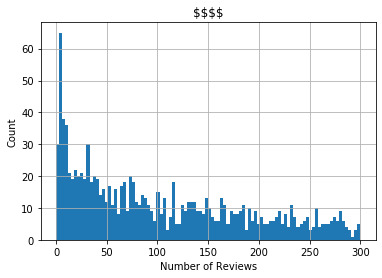

In [31]:
plt.xlabel('Number of Reviews')
plt.ylabel('Count')
plt.title('\$\$\$\$')
df[df['Price Range'] == '$$$$']['Number of Reviews'].hist(bins=100, range=(0, 300))

### Инсайт!!!
На гистограмме видно, что у большинства ресторанов с отсутствующими данными по диапазону цен количество отзывов меньше 40.
Из этого можно сделать вывод, что такие рестораны появились относительно недавно и данных по ним недостаточно.
Будем исходить из предположения, что в новых ресторанах уровень цен минимальный, так как им нужно сначала приобрести клиентуру.
Заполним недостающие данные по уровню цен таким образом:
- При 0-5 отзывов уровень цен будет минимальным '\\$'
- При 5+ отзывов уровень цен будет средним '\\$\\$ - \\$\\$\\$'

# Забегая вперед... Как ни странно, это не сработало. Точность лучше, если просто заполнить пропуски значением '\\$\\$ - \\$\\$\\$'. Дружно кекаем!!!

### Добавленный числовой признак №3. Отсутствующие данные в столбце 'Number of Reviews'

In [32]:
# Для начала создадим бинарный признак о том, было ли пропущено значение в поле 'Number of Reviews
df['Number of Reviews Was NAN'] = df['Number of Reviews'].isna()
# Заполним недостающие данные по количеству отзывов единицами
df['Number of Reviews'].fillna(1, inplace=True)

In [33]:
# Зададим функцию, возвращающую диапазон цен в зависимости от количества отзывов
# def get_price_range(reviews_count):
    
#     if reviews_count <= 5:
#         return '$'

#     return '$$ - $$$'

### Добавленный числовой признак №4. Отсутствующие данные в столбце 'Price Range'

In [34]:
# Перед заполнением пропусков создадим бинарный признак того, что раньше здесь был NAN
df['Price Range Was NAN'] = df['Price Range'].isna()
# Заполним пропуски данными функции get_price_range
# df['Price Range'].fillna(df['Number of Reviews'].apply(get_price_range), inplace=True)
# Ну уж нет. Заполним тупо значением '$$ - $$$' через fillna()
df['Price Range'].fillna('$$ - $$$', inplace=True)

### Добавленный числовой признак №5. Числовой код диапазона цен

In [35]:
# Теперь самое время перевести признак Price Range в числовой формат.
# Так как число вариаций диапазонов цен не велико сэкономим память и вычисления
# переведя строки в числа при помощи словаря и метода map вместо использования
# sklearn.preprocessing.LabelEcnoder

price_range_dict = {
    '$': 1,
    '$$ - $$$': 100,
    '$$$$': 1000
}

df['Price Range'] = df['Price Range'].map(price_range_dict)

## 2. География

In [36]:
# Еще раз посмотрим на информацию о данных в df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Restaurant_id              50000 non-null  object 
 1   City                       50000 non-null  object 
 2   Cuisine Style              38410 non-null  object 
 3   Ranking                    50000 non-null  float64
 4   Rating                     50000 non-null  float64
 5   Price Range                50000 non-null  int64  
 6   Number of Reviews          50000 non-null  float64
 7   Reviews                    49998 non-null  object 
 8   URL_TA                     50000 non-null  object 
 9   ID_TA                      50000 non-null  object 
 10  Main                       50000 non-null  bool   
 11  Name                       50000 non-null  object 
 12  Restaurants Count          50000 non-null  int64  
 13  Relative Ranking           50000 non-null  floa

In [37]:
# Как видим, информация о городах присутствует для всех ресторанов
# Посмотрим в скольких разных городах расположены рестораны, данные по которым присутствуют в датасете
df['City'].nunique()

31

In [38]:
# Посмотрим, как рестораны распределены по городам
df.groupby('City')['City'].count().sort_values(ascending=False)

City
London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

### Добавленный числовой признак №6. Код города

In [39]:
# Переведем информацию о городах в числовой формат
# с применением sklearn.preprocessign.LabelEncoder
cities_le = LabelEncoder()
cities_le.fit(df['City'])
df['City Code'] = cities_le.transform(df['City'])

In [40]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Main,Name,Restaurants Count,Relative Ranking,Price Range Was NAN,Number of Reviews Was NAN,City Code
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,100,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,True,Name-id_5569,17593,0.316603,False,False,24
1,id_1535,Stockholm,NaN,1537.0,4.0,100,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,True,Name-id_1535,3131,0.490897,True,False,27
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,1000,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,True,Name-id_352,22366,0.015783,False,False,16
3,id_3456,Berlin,NaN,3458.0,5.0,100,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,True,Name-id_3456,8110,0.426387,True,False,3
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,100,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,True,Name-id_615,3367,0.184437,False,False,21


In [41]:
# Создадим словарь, в котором ключами буду названия городов, а значениями True, если этот город столица, в противном случае False
is_capital = {
    'London': True,
    'Paris': True,
    'Madrid': True,
    'Barcelona': False,
    'Berlin': True,
    'Milan': False,
    'Rome': True,
    'Prague': True,
    'Lisbon': True,
    'Vienna': True,
    'Amsterdam': True,
    'Brussels': True,
    'Hamburg': False,
    'Munich': False,
    'Lyon': False,
    'Stockholm': True,
    'Budapest': True,
    'Warsaw': True,
    'Dublin': True,
    'Copenhagen': True,
    'Athens': True,
    'Edinburgh': True,
    'Zurich': True,
    'Oporto': False,
    'Geneva': True,
    'Krakow': True,
    'Oslo': True,
    'Helsinki': True,
    'Bratislava': True,
    'Luxembourg': True,
    'Ljubljana': True
}

### Добавленный числовой признак №7. Является ли город столицей

In [42]:
# Создадим числовой признак, является ли город столицей
df['Is Capital'] = df['City'].map(is_capital)

#### Добавим в датафрейм информацию о населении города и стране
#### Городов не так много, так что гуглим и вносим данные в словарь вручную...

In [43]:
city_population = {
    'London': 8173900,
    'Paris': 2240621,
    'Madrid': 3155360,
    'Barcelona': 1593075,
    'Berlin': 3326002,
    'Milan': 1331586,
    'Rome': 2870493,
    'Prague': 1272690,
    'Lisbon': 547733,
    'Vienna': 1765649,
    'Amsterdam': 825080,
    'Brussels': 144784,
    'Hamburg': 1718187,
    'Munich': 1364920,
    'Lyon': 496343,
    'Stockholm': 1981263,
    'Budapest': 1744665,
    'Warsaw': 1720398,
    'Dublin': 506211 ,
    'Copenhagen': 1246611,
    'Athens': 3168846,
    'Edinburgh': 476100,
    'Zurich': 402275,
    'Oporto': 221800,
    'Geneva': 196150,
    'Krakow': 756183,
    'Oslo': 673469,
    'Helsinki': 574579,
    'Bratislava': 413192,
    'Luxembourg': 576249,
    'Ljubljana': 277554
}

# Попробуем чужие данные, вдруг результат будет лучше
# Эти данные только ухудшили результат
# city_population = {'Paris': 2190327, 'Stockholm': 961609, 'London': 8908081, 'Berlin': 3644826, 'Munich': 1456039, 'Oporto': 237591,'Milan': 1378689,'Bratislava': 432864, 'Vienna': 1821582, 'Rome': 4355725, 'Barcelona': 1620343, 'Madrid': 3223334,'Dublin': 1173179,'Brussels': 179277, 'Zurich': 428737, 'Warsaw': 1758143, 'Budapest': 1752286, 'Copenhagen': 615993,'Amsterdam': 857713,'Lyon': 506615, 'Hamburg': 1841179,'Lisbon': 505526, 'Prague': 1301132, 'Oslo': 673469,'Helsinki': 643272,'Edinburgh': 488100,'Geneva': 200548, 'Ljubljana': 284355,'Athens': 664046, 'Luxembourg': 115227,'Krakow': 769498}


city_country = {
    'London': 'UK',
    'Paris': 'France',
    'Madrid': 'Spain',
    'Barcelona': 'Spain',
    'Berlin': 'Germany',
    'Milan': 'Italy',
    'Rome': 'Italy',
    'Prague': 'Czech',
    'Lisbon': 'Portugalia',
    'Vienna': 'Austria',
    'Amsterdam': 'Nederlands',
    'Brussels': '144784 ',
    'Hamburg': 'Germany',
    'Munich': 'Germany',
    'Lyon': 'France',
    'Stockholm': 'Sweden',
    'Budapest': 'Hungary',
    'Warsaw': 'Poland',
    'Dublin': 'Ireland' ,
    'Copenhagen': 'Denmark',
    'Athens': 'Greece',
    'Edinburgh': 'Schotland',
    'Zurich': 'Switzerland',
    'Oporto': 'Portugalia',
    'Geneva': 'Switzerland',
    'Krakow': 'Poland',
    'Oslo': 'Norway',
    'Helsinki': 'Finland',
    'Bratislava': 'Slovakia',
    'Luxembourg': 'Luxembourg',
    'Ljubljana': 'Slovenija'
}

### Добавленный числовой признак №8. Население

In [44]:
# Применим эти справочники к данным в столбце 'City' датафрейма df используя метод map
df['Population'] = df['City'].map(city_population)
df['Country'] = df['City'].map(city_country)

In [45]:
# Посмотрим, что получилось
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Restaurant_id              50000 non-null  object 
 1   City                       50000 non-null  object 
 2   Cuisine Style              38410 non-null  object 
 3   Ranking                    50000 non-null  float64
 4   Rating                     50000 non-null  float64
 5   Price Range                50000 non-null  int64  
 6   Number of Reviews          50000 non-null  float64
 7   Reviews                    49998 non-null  object 
 8   URL_TA                     50000 non-null  object 
 9   ID_TA                      50000 non-null  object 
 10  Main                       50000 non-null  bool   
 11  Name                       50000 non-null  object 
 12  Restaurants Count          50000 non-null  int64  
 13  Relative Ranking           50000 non-null  floa

In [46]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Main,Name,Restaurants Count,Relative Ranking,Price Range Was NAN,Number of Reviews Was NAN,City Code,Is Capital,Population,Country
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,100,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,True,Name-id_5569,17593,0.316603,False,False,24,True,2240621,France
1,id_1535,Stockholm,NaN,1537.0,4.0,100,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,True,Name-id_1535,3131,0.490897,True,False,27,True,1981263,Sweden
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,1000,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,True,Name-id_352,22366,0.015783,False,False,16,True,8173900,UK
3,id_3456,Berlin,NaN,3458.0,5.0,100,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,True,Name-id_3456,8110,0.426387,True,False,3,True,3326002,Germany
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,100,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,True,Name-id_615,3367,0.184437,False,False,21,False,1364920,Germany


In [47]:
# Проверим данные еще раз
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Restaurant_id              50000 non-null  object 
 1   City                       50000 non-null  object 
 2   Cuisine Style              38410 non-null  object 
 3   Ranking                    50000 non-null  float64
 4   Rating                     50000 non-null  float64
 5   Price Range                50000 non-null  int64  
 6   Number of Reviews          50000 non-null  float64
 7   Reviews                    49998 non-null  object 
 8   URL_TA                     50000 non-null  object 
 9   ID_TA                      50000 non-null  object 
 10  Main                       50000 non-null  bool   
 11  Name                       50000 non-null  object 
 12  Restaurants Count          50000 non-null  int64  
 13  Relative Ranking           50000 non-null  floa

### Добавленный числовой признак №9. Код страны

In [48]:
# Переведем информацию о странах в числовой формат
# с применением sklearn.preprocessign.LabelEncoder
countries_le = LabelEncoder()
countries_le.fit(df['Country'])
df['Country Code'] = countries_le.transform(df['Country'])

### Добавленный числовой признак №10. Сколько человек населения в среднем приходится на один ресторан

In [49]:
# Добавим числовой признак 'People Per Restaurant' = 'Population' / 'Restaurants Count'
df['People Per Restaurant'] = df['Population'] / df['Restaurants Count']

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Restaurant_id              50000 non-null  object 
 1   City                       50000 non-null  object 
 2   Cuisine Style              38410 non-null  object 
 3   Ranking                    50000 non-null  float64
 4   Rating                     50000 non-null  float64
 5   Price Range                50000 non-null  int64  
 6   Number of Reviews          50000 non-null  float64
 7   Reviews                    49998 non-null  object 
 8   URL_TA                     50000 non-null  object 
 9   ID_TA                      50000 non-null  object 
 10  Main                       50000 non-null  bool   
 11  Name                       50000 non-null  object 
 12  Restaurants Count          50000 non-null  int64  
 13  Relative Ranking           50000 non-null  floa

In [51]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Restaurants Count,Relative Ranking,Price Range Was NAN,Number of Reviews Was NAN,City Code,Is Capital,Population,Country,Country Code,People Per Restaurant
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,100,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,...,17593,0.316603,False,False,24,True,2240621,France,5,127.358665
1,id_1535,Stockholm,NaN,1537.0,4.0,100,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,...,3131,0.490897,True,False,27,True,1981263,Sweden,20,632.789205
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,1000,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,...,22366,0.015783,False,False,16,True,8173900,UK,22,365.460968
3,id_3456,Berlin,NaN,3458.0,5.0,100,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,...,8110,0.426387,True,False,3,True,3326002,Germany,6,410.111221
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,100,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,...,3367,0.184437,False,False,21,False,1364920,Germany,6,405.381645


## 3. Виды кухни

In [52]:
# Проверим данные
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Restaurant_id              50000 non-null  object 
 1   City                       50000 non-null  object 
 2   Cuisine Style              38410 non-null  object 
 3   Ranking                    50000 non-null  float64
 4   Rating                     50000 non-null  float64
 5   Price Range                50000 non-null  int64  
 6   Number of Reviews          50000 non-null  float64
 7   Reviews                    49998 non-null  object 
 8   URL_TA                     50000 non-null  object 
 9   ID_TA                      50000 non-null  object 
 10  Main                       50000 non-null  bool   
 11  Name                       50000 non-null  object 
 12  Restaurants Count          50000 non-null  int64  
 13  Relative Ranking           50000 non-null  floa

In [53]:
# Получим Series столбца 'Cuisine Style' без пропусков данных
cuisines = df['Cuisine Style'].dropna()
cuisines

0                 ['European', 'French', 'International']
2       ['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...
4       ['German', 'Central European', 'Vegetarian Fri...
6                                    ['Italian', 'Pizza']
7                                             ['Italian']
                              ...                        
9993                           ['European', 'Portuguese']
9994          ['Mediterranean', 'European', 'Portuguese']
9995    ['Caribbean', 'Barbecue', 'Jamaican', 'Vegetar...
9996         ['Indian', 'Asian', 'Nepali', 'Bangladeshi']
9998                                          ['Italian']
Name: Cuisine Style, Length: 38410, dtype: object

In [54]:
type(cuisines.iloc[0])

str

#### Как видим, данные в этом Series представляют собой строковые представления списков в соответствии с синтаксисом языка Python.

### Добавленный числовой признак №11. Отсутствующие данные в столбце 'Cuisine Style'

In [55]:
# Создадим признак 'Cusine Style Was NAN', показывающий, что в столбце 'Cuisine Style' данные отсутствовали
df['Cuisine Style Was NAN'] = df['Cuisine Style'].isna()
# Заполним недостающие данные значением ['Usual']
df['Cuisine Style'].fillna("['Usual']", inplace=True)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Restaurant_id              50000 non-null  object 
 1   City                       50000 non-null  object 
 2   Cuisine Style              50000 non-null  object 
 3   Ranking                    50000 non-null  float64
 4   Rating                     50000 non-null  float64
 5   Price Range                50000 non-null  int64  
 6   Number of Reviews          50000 non-null  float64
 7   Reviews                    49998 non-null  object 
 8   URL_TA                     50000 non-null  object 
 9   ID_TA                      50000 non-null  object 
 10  Main                       50000 non-null  bool   
 11  Name                       50000 non-null  object 
 12  Restaurants Count          50000 non-null  int64  
 13  Relative Ranking           50000 non-null  floa

In [57]:
# Применим библиотеку ast для перевода строковых представлений списков в соответствии с ситнтаксисом языка Python в списки Python
def get_list(list_string):
    result_list = ast.literal_eval(list_string)
    return result_list

# Преобразуем данные в столбце 'Cuisine Style' к списку
cuisines = cuisines.apply(get_list)

# Создадим словарь кухонь
cuisines_dict = dict()

for cuisines_list in cuisines:
    for cuisine in cuisines_list:
        try:
            cuisines_dict[cuisine] += 1
        except:
            cuisines_dict[cuisine] = 1

# Выведем количество различных кухонь

print(f'Множество различных кухонь: {len(cuisines_dict)}')

Множество различных кухонь: 125


### Добавленный числовой признак №12. Количество различных кухонь, представленных в ресторане

In [58]:
# Создадим еще один числовой признак 'cuisines_count'
def get_cuisines_count(cuisines):
    if type(cuisines) == str:
        return len(get_list(cuisines))
    return 1

df['Cuisines Count'] = df['Cuisine Style'].apply(get_cuisines_count)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Restaurant_id              50000 non-null  object 
 1   City                       50000 non-null  object 
 2   Cuisine Style              50000 non-null  object 
 3   Ranking                    50000 non-null  float64
 4   Rating                     50000 non-null  float64
 5   Price Range                50000 non-null  int64  
 6   Number of Reviews          50000 non-null  float64
 7   Reviews                    49998 non-null  object 
 8   URL_TA                     50000 non-null  object 
 9   ID_TA                      50000 non-null  object 
 10  Main                       50000 non-null  bool   
 11  Name                       50000 non-null  object 
 12  Restaurants Count          50000 non-null  int64  
 13  Relative Ranking           50000 non-null  floa

In [59]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Price Range Was NAN,Number of Reviews Was NAN,City Code,Is Capital,Population,Country,Country Code,People Per Restaurant,Cuisine Style Was NAN,Cuisines Count
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,100,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,...,False,False,24,True,2240621,France,5,127.358665,False,3
1,id_1535,Stockholm,['Usual'],1537.0,4.0,100,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,...,True,False,27,True,1981263,Sweden,20,632.789205,True,1
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,1000,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,...,False,False,16,True,8173900,UK,22,365.460968,False,7
3,id_3456,Berlin,['Usual'],3458.0,5.0,100,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,...,True,False,3,True,3326002,Germany,6,410.111221,True,1
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,100,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,...,False,False,21,False,1364920,Germany,6,405.381645,False,3


#### Количество типов кухонь, которые предлагаются только в одном ресторане.

In [60]:
uno_cuisine_count = 0
unique_cuisines = set()
for cuisine, count in cuisines_dict.items():
    if count == 1:
        unique_cuisines.add(cuisine)
        uno_cuisine_count += 1
print(f'Количество типов кухонь, предлагаемых только в одном ресторане: {uno_cuisine_count}')
print(f'Уникальные кухни:')
unique_cuisines

Количество типов кухонь, предлагаемых только в одном ресторане: 4
Уникальные кухни:


{'Burmese', 'Latvian', 'Salvadoran', 'Xinjiang'}

### Добавленный числовой признак №13. Присутствует ли среди кухонь ресторана кухня присущая только ему.

In [61]:
# На основе этих данных создадим столбец с числовыми данными is_unique_cuisine, указывающими на уникальную кухню данного ресторана
def is_unique_cuisine(cuisine):
    cuisines_list = get_list(cuisine)
    cuisines_set = set(cuisines_list)
    return not cuisines_set.isdisjoint(unique_cuisines)

df['Unique Cuisine'] = df['Cuisine Style'].apply(is_unique_cuisine)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Restaurant_id              50000 non-null  object 
 1   City                       50000 non-null  object 
 2   Cuisine Style              50000 non-null  object 
 3   Ranking                    50000 non-null  float64
 4   Rating                     50000 non-null  float64
 5   Price Range                50000 non-null  int64  
 6   Number of Reviews          50000 non-null  float64
 7   Reviews                    49998 non-null  object 
 8   URL_TA                     50000 non-null  object 
 9   ID_TA                      50000 non-null  object 
 10  Main                       50000 non-null  bool   
 11  Name                       50000 non-null  object 
 12  Restaurants Count          50000 non-null  int64  
 13  Relative Ranking           50000 non-null  floa

In [63]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Number of Reviews Was NAN,City Code,Is Capital,Population,Country,Country Code,People Per Restaurant,Cuisine Style Was NAN,Cuisines Count,Unique Cuisine
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,100,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,...,False,24,True,2240621,France,5,127.358665,False,3,False
1,id_1535,Stockholm,['Usual'],1537.0,4.0,100,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,...,False,27,True,1981263,Sweden,20,632.789205,True,1,False
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,1000,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,...,False,16,True,8173900,UK,22,365.460968,False,7,False
3,id_3456,Berlin,['Usual'],3458.0,5.0,100,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,...,False,3,True,3326002,Germany,6,410.111221,True,1,False
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,100,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,...,False,21,False,1364920,Germany,6,405.381645,False,3,False


### Добавленная группа бинарарных признаков №№14 (126 признаков в отдельном датасете). Наличие или отсутствие соответствующей кухни в меню ресторана.

In [64]:
# Используем sklearn.preprocessing.MultiLabelBinarizer кодирование для признака Cuisine Style
mlb = MultiLabelBinarizer()
encoded = pd.DataFrame(mlb.fit_transform(df['Cuisine Style'].apply(get_list)),
                       columns=mlb.classes_, index=df.index)

In [65]:
#  Посмотрим, что получилось
encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 9999
Columns: 126 entries, Afghani to Yunnan
dtypes: int64(126)
memory usage: 48.4 MB


In [66]:
encoded.head()

,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,...,Usual,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


Пока оставим новые признаки в отдельном датафрейме encoded,
так как после конкатенации 126 бинарных признаков в основной датафрейм
анализировать его через df.info() становится затруднительным.
Конкатенацию в дальнейшем будем производить при помощи кода:
``` python
pd.concat([df, encoded], axis=1)
```

## 4. Отзывы

In [67]:
# Сначала заменим nan в строковых представлениях списков отзывов и их дат на строку с датой по-умолчанию
# а также заменим пустой список вида [] на список с незаполненными элементами вида ['01/01/2000', '01/01/2000']
def nan_to_default_date(list_string):
    try:
        list_string = list_string.replace('[nan', "['01/01/2000'")
        list_string = list_string.replace('nan]', "'01/01/2000']")
        list_string = list_string.replace('[]', "['01/01/2000', '01/01/2000']")
    except:
        list_string = "[['None Review', 'None Review'], ['01/01/2000', '01/01/2000']]"
    return list_string

df['Reviews'] = df['Reviews'].apply(nan_to_default_date)

In [68]:
# Преобразуем данные в столбце 'Reviews' к типу list
last_review = []
last_review_date = []
prelast_review = []
prelast_review_date = []
for reviews in df['Reviews']:
    reviews_list = get_list(reviews)
    if len(reviews_list) == 2:
        if (len(reviews_list[0]) == 2 and len(reviews_list[1]) == 2):
            last_review.append(reviews_list[0][0])
            last_review_date.append(reviews_list[1][0])
            prelast_review.append(reviews_list[0][1])
            prelast_review_date.append(reviews_list[1][1])
        elif (len(reviews_list[0]) == 1 and len(reviews_list[1]) == 1):
            last_review.append(reviews_list[0][0])
            last_review_date.append(reviews_list[1][0])
            prelast_review.append('None review')
            prelast_review_date.append('01/01/2000')
        else:
            print(reviews_list)

In [69]:
# Добавим новые признаки:
# - последний отзыв
df['Last Review'] = last_review
# - дата последнего отзыва
df['Last Review Date'] = last_review_date
# - предпоследний отзыв
df['Prelast Review'] = prelast_review
# - дата предпоследнего отзыва
df['Prelast Review Date'] = prelast_review_date

In [70]:
# Переведем даты в формат datetime
df['Last Review Date'] = pd.to_datetime(df['Last Review Date'])
df['Prelast Review Date'] = pd.to_datetime(df['Prelast Review Date'])

In [71]:
# Посмотрим на данные
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 9999
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Restaurant_id              50000 non-null  object        
 1   City                       50000 non-null  object        
 2   Cuisine Style              50000 non-null  object        
 3   Ranking                    50000 non-null  float64       
 4   Rating                     50000 non-null  float64       
 5   Price Range                50000 non-null  int64         
 6   Number of Reviews          50000 non-null  float64       
 7   Reviews                    50000 non-null  object        
 8   URL_TA                     50000 non-null  object        
 9   ID_TA                      50000 non-null  object        
 10  Main                       50000 non-null  bool          
 11  Name                       50000 non-null  object        
 12  Resta

In [72]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Country,Country Code,People Per Restaurant,Cuisine Style Was NAN,Cuisines Count,Unique Cuisine,Last Review,Last Review Date,Prelast Review,Prelast Review Date
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,100,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,...,France,5,127.358665,False,3,False,Good food at your doorstep,2017-12-31,A good hotel restaurant,2017-11-20
1,id_1535,Stockholm,['Usual'],1537.0,4.0,100,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,...,Sweden,20,632.789205,True,1,False,Unique cuisine,2017-07-06,Delicious Nepalese food,2016-06-19
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,1000,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,...,UK,22,365.460968,False,7,False,Catch up with friends,2018-01-08,Not exceptional,2018-01-06
3,id_3456,Berlin,['Usual'],3458.0,5.0,100,3.0,"[['01/01/2000', '01/01/2000'], ['01/01/2000', ...",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,...,Germany,6,410.111221,True,1,False,01/01/2000,2000-01-01,01/01/2000,2000-01-01
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,100,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,...,Germany,6,405.381645,False,3,False,Best place to try a Bavarian food,2017-11-18,Nice building but improvements need to be...,2017-02-19


### Добавленный числовой признак №15. Количество дней, прошедших между последними двумя отзывами

In [73]:
df['Days Between Reviews'] = (df['Last Review Date'] - df['Prelast Review Date'])
def get_days(timedelta):
    return timedelta.days
df['Days Between Reviews'] = df['Days Between Reviews'].apply(get_days)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 9999
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Restaurant_id              50000 non-null  object        
 1   City                       50000 non-null  object        
 2   Cuisine Style              50000 non-null  object        
 3   Ranking                    50000 non-null  float64       
 4   Rating                     50000 non-null  float64       
 5   Price Range                50000 non-null  int64         
 6   Number of Reviews          50000 non-null  float64       
 7   Reviews                    50000 non-null  object        
 8   URL_TA                     50000 non-null  object        
 9   ID_TA                      50000 non-null  object        
 10  Main                       50000 non-null  bool          
 11  Name                       50000 non-null  object        
 12  Resta

In [75]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Country Code,People Per Restaurant,Cuisine Style Was NAN,Cuisines Count,Unique Cuisine,Last Review,Last Review Date,Prelast Review,Prelast Review Date,Days Between Reviews
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,100,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,...,5,127.358665,False,3,False,Good food at your doorstep,2017-12-31,A good hotel restaurant,2017-11-20,41
1,id_1535,Stockholm,['Usual'],1537.0,4.0,100,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,...,20,632.789205,True,1,False,Unique cuisine,2017-07-06,Delicious Nepalese food,2016-06-19,382
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,1000,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,...,22,365.460968,False,7,False,Catch up with friends,2018-01-08,Not exceptional,2018-01-06,2
3,id_3456,Berlin,['Usual'],3458.0,5.0,100,3.0,"[['01/01/2000', '01/01/2000'], ['01/01/2000', ...",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,...,6,410.111221,True,1,False,01/01/2000,2000-01-01,01/01/2000,2000-01-01,0
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,100,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,...,6,405.381645,False,3,False,Best place to try a Bavarian food,2017-11-18,Nice building but improvements need to be...,2017-02-19,272


### Добавленный числовой признак №16. Количество дней между текущей датой и датой размещения последнего отзыва о ресторане.

#### Обоснование: рейтинг ресторана может зависеть не только от того, сколько времени прошло между размещением последних двух отзывов, но и от того сколько дней прошло с момента размещения последнего отзыва до текущей даты.

In [76]:
df['Days Since Last Review'] = df['Last Review Date'].apply(lambda date: CURRENT_DATE - date)
df['Days Since Last Review'] = df['Days Since Last Review'].apply(get_days)

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Restaurant_id              50000 non-null  object        
 1   City                       50000 non-null  object        
 2   Cuisine Style              50000 non-null  object        
 3   Ranking                    50000 non-null  float64       
 4   Rating                     50000 non-null  float64       
 5   Price Range                50000 non-null  int64         
 6   Number of Reviews          50000 non-null  float64       
 7   Reviews                    50000 non-null  object        
 8   URL_TA                     50000 non-null  object        
 9   ID_TA                      50000 non-null  object        
 10  Main                       50000 non-null  bool          
 11  Name                       50000 non-null  object        
 12  Resta

In [78]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,People Per Restaurant,Cuisine Style Was NAN,Cuisines Count,Unique Cuisine,Last Review,Last Review Date,Prelast Review,Prelast Review Date,Days Between Reviews,Days Since Last Review
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,100,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,...,127.358665,False,3,False,Good food at your doorstep,2017-12-31,A good hotel restaurant,2017-11-20,41,783
1,id_1535,Stockholm,['Usual'],1537.0,4.0,100,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,...,632.789205,True,1,False,Unique cuisine,2017-07-06,Delicious Nepalese food,2016-06-19,382,961
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,1000,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,...,365.460968,False,7,False,Catch up with friends,2018-01-08,Not exceptional,2018-01-06,2,775
3,id_3456,Berlin,['Usual'],3458.0,5.0,100,3.0,"[['01/01/2000', '01/01/2000'], ['01/01/2000', ...",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,...,410.111221,True,1,False,01/01/2000,2000-01-01,01/01/2000,2000-01-01,0,7357
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,100,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,...,405.381645,False,3,False,Best place to try a Bavarian food,2017-11-18,Nice building but improvements need to be...,2017-02-19,272,826


### Добавленный признак №17. Числовая часть ID_TA.

In [79]:
# Создадим числовой признак 'ID_TA Numeric' на основе 'ID_TA'
df['ID_TA Numeric'] = df['ID_TA'].apply(lambda id_ta: int(id_ta[1:]))

### Добавленный признак №18. Нормализованный диапазон цен в зависимости от положения ресторана среди всех ресторанов города. Идея: вряд ли хорошие отзывы будут у не самых крутых ресторанов с самыми крутыми ценами и наоборот.

In [80]:
# Создадим числовой признак 'Relative Price Range' на основе признаков 'Price Range' и 'Relative Ranking'
# df['Relative Price Range'] = df['Price Range'] / df['Relative Ranking']
df['Relative Price Range'] = df['Price Range'] / df['Relative Ranking']

### Добавленный признак №19. Количество людей в городе, приходящихся на 1 отзыв может характеризовать популярность ресторана.
## Почему-то не сработало. Точность модели немного ухудшилась. Дружно кекаем!!!

In [81]:
# Создадим числовой признак 'People Per Review' на основе признаков 'Population' и 'Number of Reviews'
df['People Per Review'] = df['Population'] / df['Number of Reviews']

### Добавленные признаки №№20 и 21. Сентимент-оценка последнего и предспоследнего отзыва соответственно...
#### Простейший сентимент анализ основан на словаре, доступном по адресу: https://github.com/formikaio/sentiment-analysis-dictionaries

In [82]:
df['Reviews'].iloc[-1]

"[['Ethiopian Dining in Pleasant Space'], ['07/30/2016']]"

In [83]:
# Создадим словарь на основе данных из sentiment_dict_en_1.csv
import csv
sentiment_dict = dict()
with open('data/sentiment_dict_en_1.csv', mode='r') as infile:
    reader = csv.reader(infile)
    for row in reader:
        sentiment_dict[row[0]] = int(row[1])

In [84]:
# Для начала вычистим из отзывов знаки пунктуации и приведем все к нижнему регистру:
import string

def clean_review(review):
    clean_rev = review.lower()
    clean_rev = ''.join(c for c in clean_rev if c not in string.punctuation)
    return clean_rev

df['Last Review'] = df['Last Review'].apply(clean_review)
df['Prelast Review'] = df['Prelast Review'].apply(clean_review)

In [85]:
# Сформируем списки слов отзывов
last_review_words = list(df['Last Review'].apply(lambda x: x.split()))
prelast_review_words = list(df['Prelast Review'].apply(lambda x: x.split()))

In [86]:
# Посчитаем итоговые оценки используя справочник слов
last_review_setntiment_score = []
prelast_review_setntiment_score = []

# Для каждого списка слов
for i in range(50000):
    
    # Для последних отзывов:
    # Зададим начальное значение сентимент-оценки
    sentiment_score = 0
    # Для каждого слова в списке слов
    for word in last_review_words[i]:
        # Пытаемся найти соответствие в словаре
        try:
            # И если нашли, то меняем значение сентимент-оценки, прибавляя к текущему значению оценки значение из словаря для данного слова
            sentiment_score += sentiment_dict[word]
        except:
            # Если не нашли, то ничего не меняем
            pass
    # Добавляем полученное значение к списку сентимент-оценок
    last_review_setntiment_score.append(sentiment_score)
    
    # Для предпоследних отзывов:
    # Зададим начальное значение сентимент-оценки
    sentiment_score = 0
    # Для каждого слова в списке слов
    for word in prelast_review_words[i]:
        # Пытаемся найти соответствие в словаре
        try:
            # И если нашли, то меняем значение сентимент-оценки, прибавляя к текущему значению оценки значение из словаря для данного слова
            sentiment_score += sentiment_dict[word]
        except:
            # Если не нашли, то ничего не меняем
            pass
    # Добавляем полученное значение к списку сентимент-оценок
    prelast_review_setntiment_score.append(sentiment_score)


In [87]:
# Проверяем длины списков сентимент-оценок
print(len(last_review_setntiment_score))
print(len(prelast_review_setntiment_score))


50000
50000


In [88]:
# Добавим их в наш датасет
df['Last Review Sentiment Score'] = last_review_setntiment_score
df['Prelast Review Sentiment Score'] = prelast_review_setntiment_score


In [89]:
# Посмотрим, что получилось
df[['Last Review', 'Last Review Sentiment Score', 'Prelast Review', 'Prelast Review Sentiment Score']][:10]

,Last Review,Last Review Sentiment Score,Prelast Review,Prelast Review Sentiment Score
0,good food at your doorstep,3,a good hotel restaurant,3
1,unique cuisine,0,delicious nepalese food,3
2,catch up with friends,0,not exceptional,-2
3,01012000,0,01012000,0
4,best place to try a bavarian food,3,nice building but improvements need to be,3
5,there are better 3 star hotel bars,-2,amazing views friendly service and good q,8
6,excellent simple local eatery,0,excellent restaurant,0
7,wasting of money,-2,excellent cuisine,0
8,01012000,0,01012000,0
9,clean efficient staff,2,nice little pizza takeaway place,3


### Добавленный признак №23. Средний уровень цен по городам

In [90]:
df['City Mean Price'] = df['City'].map(df.groupby('City')['Price Range'].mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 9999
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Restaurant_id                   50000 non-null  object        
 1   City                            50000 non-null  object        
 2   Cuisine Style                   50000 non-null  object        
 3   Ranking                         50000 non-null  float64       
 4   Rating                          50000 non-null  float64       
 5   Price Range                     50000 non-null  int64         
 6   Number of Reviews               50000 non-null  float64       
 7   Reviews                         50000 non-null  object        
 8   URL_TA                          50000 non-null  object        
 9   ID_TA                           50000 non-null  object        
 10  Main                            50000 non-null  bool          
 11  Nam

### Добавленный признак №24. Отношение уровня цен в ресторане к среднему уровню цен в городе

In [91]:
df['Relative Price Range by City'] = df['Price Range'] / df['City Mean Price']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 9999
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Restaurant_id                   50000 non-null  object        
 1   City                            50000 non-null  object        
 2   Cuisine Style                   50000 non-null  object        
 3   Ranking                         50000 non-null  float64       
 4   Rating                          50000 non-null  float64       
 5   Price Range                     50000 non-null  int64         
 6   Number of Reviews               50000 non-null  float64       
 7   Reviews                         50000 non-null  object        
 8   URL_TA                          50000 non-null  object        
 9   ID_TA                           50000 non-null  object        
 10  Main                            50000 non-null  bool          
 11  Nam

### Добавленный признак №25. Среднее количество кухонь в ресторанах по городам

In [92]:
# Идея взята из ноутбука Евгении Кондрашечкиной
df['Cuisines Count Mean by City'] = df['City'].map(df.groupby('City')['Cuisines Count'].mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 9999
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Restaurant_id                   50000 non-null  object        
 1   City                            50000 non-null  object        
 2   Cuisine Style                   50000 non-null  object        
 3   Ranking                         50000 non-null  float64       
 4   Rating                          50000 non-null  float64       
 5   Price Range                     50000 non-null  int64         
 6   Number of Reviews               50000 non-null  float64       
 7   Reviews                         50000 non-null  object        
 8   URL_TA                          50000 non-null  object        
 9   ID_TA                           50000 non-null  object        
 10  Main                            50000 non-null  bool          
 11  Nam

### Добавленный признак №26. Плотность населения по городам

In [93]:
# Идея и данные взяты из ноутбука Евгении Кондрашечкиной
population_density = {'Paris': 20781, 'Stockholm': 5139.7, 'London': 5667, 'Berlin': 4088, 'Munich': 4713, 'Oporto': 5703,
       'Milan':7588.97, 'Bratislava':1171, 'Vienna':4502.88, 'Rome':2234, 'Barcelona':15779, 'Madrid':8653.5,
       'Dublin':3689, 'Brussels':5497, 'Zurich':4666, 'Warsaw':3449, 'Budapest':3330.5, 'Copenhagen':6214.7,
       'Amsterdam':4768, 'Lyon':10041, 'Hamburg':2388.57, 'Lisbon':6243.9, 'Prague':2506, 'Oslo':1483.41,
       'Helsinki':899, 'Edinburgh':4140, 'Geneva':12589, 'Ljubljana':1736, 'Athens':7500,
       'Luxembourg':2240, 'Krakow':2344}

df['Population Density'] = df['City'].map(population_density)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 9999
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Restaurant_id                   50000 non-null  object        
 1   City                            50000 non-null  object        
 2   Cuisine Style                   50000 non-null  object        
 3   Ranking                         50000 non-null  float64       
 4   Rating                          50000 non-null  float64       
 5   Price Range                     50000 non-null  int64         
 6   Number of Reviews               50000 non-null  float64       
 7   Reviews                         50000 non-null  object        
 8   URL_TA                          50000 non-null  object        
 9   ID_TA                           50000 non-null  object        
 10  Main                            50000 non-null  bool          
 11  Nam

In [94]:
# Данные и идея взяты из ноутбука Евгении Кондрашечкиной
average_income = {'Paris': 3332, 'Stockholm': 2893, 'London': 2703, 'Berlin': 4392, 'Munich': 4392, 'Oporto': 1288,
       'Milan':2726, 'Bratislava':1283, 'Vienna':2940, 'Rome':2726, 'Barcelona':2133, 'Madrid':2133,
       'Dublin':3671, 'Brussels':3930, 'Zurich':6244, 'Warsaw':1253, 'Budapest':1187, 'Copenhagen':6192,
       'Amsterdam':3238, 'Lyon':3332, 'Hamburg':4392, 'Lisbon':1288, 'Prague':1454, 'Oslo':5450,
       'Helsinki':3908, 'Edinburgh':2703, 'Geneva':6244, 'Ljubljana':1914, 'Athens':1203,
       'Luxembourg':5854, 'Krakow':1253}
df['Average Income by City'] = df['City'].map(average_income)

### Тренируем и тестируем модель

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 9999
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Restaurant_id                   50000 non-null  object        
 1   City                            50000 non-null  object        
 2   Cuisine Style                   50000 non-null  object        
 3   Ranking                         50000 non-null  float64       
 4   Rating                          50000 non-null  float64       
 5   Price Range                     50000 non-null  int64         
 6   Number of Reviews               50000 non-null  float64       
 7   Reviews                         50000 non-null  object        
 8   URL_TA                          50000 non-null  object        
 9   ID_TA                           50000 non-null  object        
 10  Main                            50000 non-null  bool          
 11  Nam

In [96]:
# Подготовим датафрейм, содержащий все числовые признаки и основанный на данных из основного датасета
# Для удобства сформируем множество численных признаков, на которых можно тренировать модель:
train_features_set = {
    'Ranking',
    'Price Range',
    'Number of Reviews',
    'Restaurants Count',
    'Relative Ranking',
    'City Code',
    'Is Capital',
    'Population',
    'Country Code',
    'People Per Restaurant',
    'Cuisines Count',
    'Unique Cuisine',
    'Days Between Reviews',
    'Days Since Last Review',
    'ID_TA Numeric',
    'Relative Price Range',
#     'People Per Review',
    'Last Review Sentiment Score',
    'Prelast Review Sentiment Score',
    'City Mean Price',
    'Relative Price Range by City',
    'Cuisines Count Mean by City',
    'Population Density',
    'Average Income by City',
#     'Price Range Was NAN',
#     'Number of Reviews Was NAN',
#     'Cuisine Style Was NAN',
}

# Дополним этот список бинарными признаками присутствия той или иной кухни в меню ресторана
train_features_set = train_features_set.union(set(encoded.columns))

# Создадим объединенный датафрейм для тренировки модели, исключив из него данные из датасета kaggle_task.csv
train_df = pd.concat([df, encoded], axis=1)
# train_df = df.copy()
train_df = train_df[train_df['Main']]
train_df = train_df[train_features_set]

In [97]:
# Готовим данные
X = train_df
y = df[df['Main']]['Rating']
# В данном случае мы тренируем модель на всей выборке

In [98]:
# Создаем модель
rfm = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [99]:
# И наконец тренируем нашу модель
rfm.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.1s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=1, warm_start=False)

In [100]:
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = rfm.predict(X)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished


In [101]:
# Поcмотрим на предсказанные данные:
y_pred

array([3.505, 3.96 , 4.475, ..., 4.41 , 4.015, 3.045])

In [102]:
# И сразу видим возможность улучшения точности модели.
# Сравним с исходными данными:
df['Rating'].unique()

array([3.5, 4. , 4.5, 5. , 3. , 2.5, 2. , 1. , 1.5, 0. ])

In [103]:
# Видим разницу в том, что реальные рейтинги всегда кратны 0.5
# Напишем функцию соответствующей корректировки предсказанных рейтингов
def fine_rating_pred(rating_pred):
    if rating_pred <= 0.5:
        return 0.0
    if rating_pred <= 1.5:
        return 1.0
    if rating_pred <= 1.75:
        return 1.5
    if rating_pred <= 2.25:
        return 2.0
    if rating_pred <= 2.75:
        return 2.5
    if rating_pred <= 3.25:
        return 3.0
    if rating_pred <= 3.75:
        return 3.5
    if rating_pred <= 4.25:
        return 4.0
    if rating_pred <= 4.75:
        return 4.5
    return 5.0

In [104]:
# Применим такое округление
for i in range(len(y_pred)):
    y_pred[i] = fine_rating_pred(y_pred[i])
    
# Применим другое округление
def round_of_rating(number):
    return round(number * 2) / 2

y_pred_rounded = list(map(round_of_rating,y_pred))

In [105]:
y_pred

array([3.5, 4. , 4.5, ..., 4.5, 4. , 3. ])

In [106]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
mae = metrics.mean_absolute_error(y, y_pred)
print(f'Достигнуто значение MAE: {mae}')

Достигнуто значение MAE: 0.0145375


In [107]:
# Сравниваем предсказанные значения (y_pred_rounded) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
mae = metrics.mean_absolute_error(y, y_pred_rounded)
print(f'При применении чужого кода округления достигнуто значение MAE: {mae}')

При применении чужого кода округления достигнуто значение MAE: 0.0145375


In [108]:
# Best MAE: 0.0144125
# Previews MAE: 0.014375

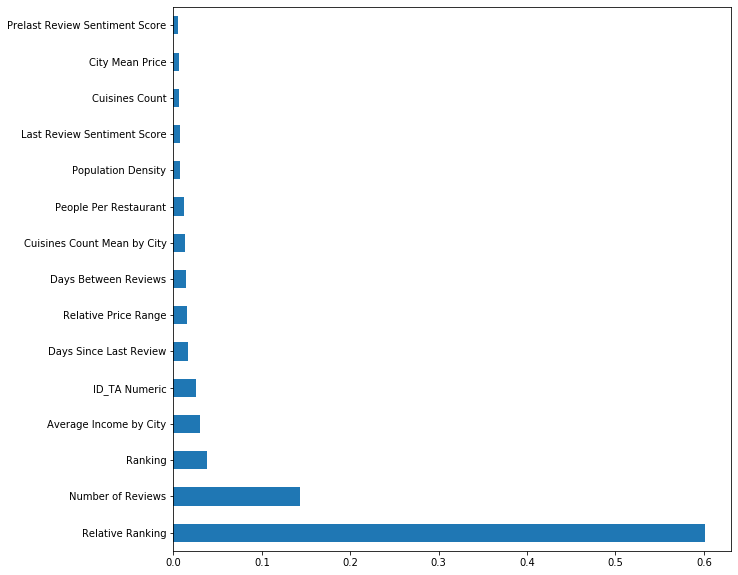

In [109]:
plt.figure(figsize=(10,10))
feat_importances = pd.Series(rfm.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Подготовка и сохранение конечного результата

In [110]:
# Создадим датафрейм с валидационными данными для передачи в модель для предсказания рейтингов
# Создадим объединенный датафрейм для предсказания рейтингов, включив в него данные только из датасета kaggle_task.csv
valid_df = pd.concat([df, encoded], axis=1)
valid_df = valid_df[~valid_df['Main']]
valid_df = valid_df[train_features_set]

In [111]:
# Произведем предсказания
valid_y_pred = rfm.predict(valid_df)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


In [112]:
# Применим округление
for i in range(len(valid_y_pred)):
    valid_y_pred[i] = fine_rating_pred(valid_y_pred[i])

In [113]:
# Создадим датасет конечного результата submission_df
submission_df = pd.DataFrame()

In [114]:
# Запишем в него требуемые данные
submission_df['Restaurant_id'] = df[~df['Main']]['Restaurant_id']
submission_df['Rating'] = valid_y_pred

In [115]:
# Проверим, что получилось
submission_df

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
...,...,...
9995,id_9995,4.5
9996,id_9996,4.0
9997,id_9997,3.0
9998,id_9998,4.5


In [116]:
# Сохраним результат в файл
submission_df.to_csv('submission.csv', index=False)

In [120]:
fd = pd.read_csv(join('ta_scrapy', 'fresh_data.csv'))

In [121]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58215 entries, 0 to 58214
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   NewName                 58169 non-null  object
 1   NewCity                 52186 non-null  object
 2   New Cuisine Style       54756 non-null  object
 3   New Ranking             52219 non-null  object
 4   New Restaurants Count   52219 non-null  object
 5   New Ranking Normalized  52219 non-null  object
 6   New Rating              58120 non-null  object
 7   New Price Range         49080 non-null  object
 8   New Number of Reviews   56385 non-null  object
 9   URL_TA                  58215 non-null  object
dtypes: object(10)
memory usage: 4.4+ MB


In [125]:
fd.drop_duplicates('URL_TA', inplace=True)

In [126]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49702 entries, 0 to 58020
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   NewName                 49679 non-null  object
 1   NewCity                 44023 non-null  object
 2   New Cuisine Style       46395 non-null  object
 3   New Ranking             44052 non-null  object
 4   New Restaurants Count   44052 non-null  object
 5   New Ranking Normalized  44052 non-null  object
 6   New Rating              49644 non-null  object
 7   New Price Range         41002 non-null  object
 8   New Number of Reviews   48167 non-null  object
 9   URL_TA                  49702 non-null  object
dtypes: object(10)
memory usage: 4.2+ MB
